In [26]:
# !unzip data.zip

In [27]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

# ---

# ## 2. Hyperparameters and Configuration
# 모델과 데이터 로딩에 필요한 주요 파라미터를 설정합니다.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 100
EPOCHS = 30

# 데이터 경로 설정
try:
    data_path = './Bottle Images/Bottle Images'
    if not os.path.exists(data_path):
        raise FileNotFoundError
except FileNotFoundError:
    print("="*50)
    print(f"경고: '{data_path}' 경로를 찾을 수 없습니다.")
    print("데이터셋 경로를 올바르게 수정해주세요.")
    print("="*50)
    data_path = 'path_to_your_data'

Class names found: ['Beer Bottles', 'Plastic Bottles', 'Soda Bottle', 'Water Bottle', 'Wine Bottle']


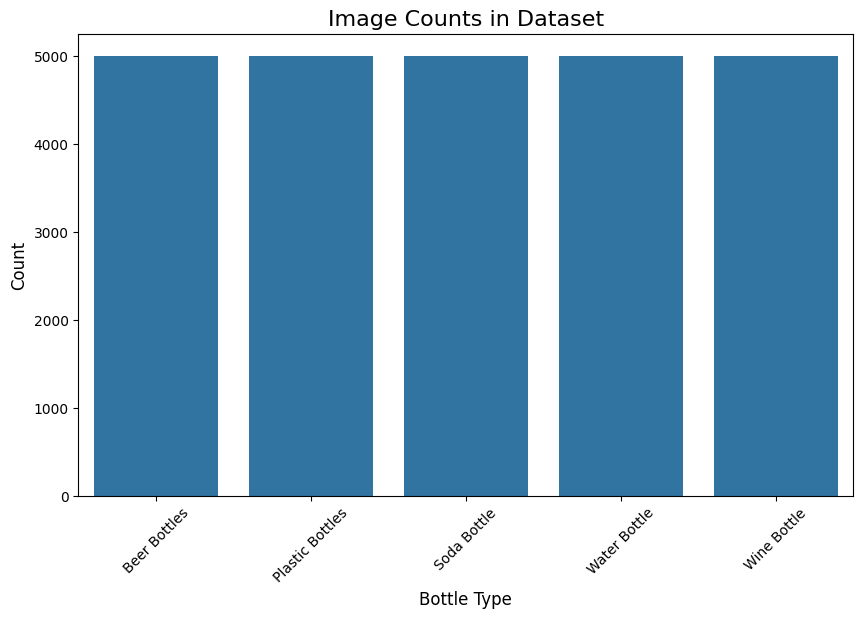

In [28]:
# ## 3. Exploratory Data Analysis (EDA)
class_names = sorted([d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))])
if not class_names:
    print(f"'{data_path}' 내에 클래스 폴더가 없습니다. EDA를 건너뜁니다.")
else:
    print(f"Class names found: {class_names}")

    # ### 3.1. Class Distribution
    class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in class_names}
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Image Counts in Dataset', fontsize=16)
    plt.xlabel('Bottle Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

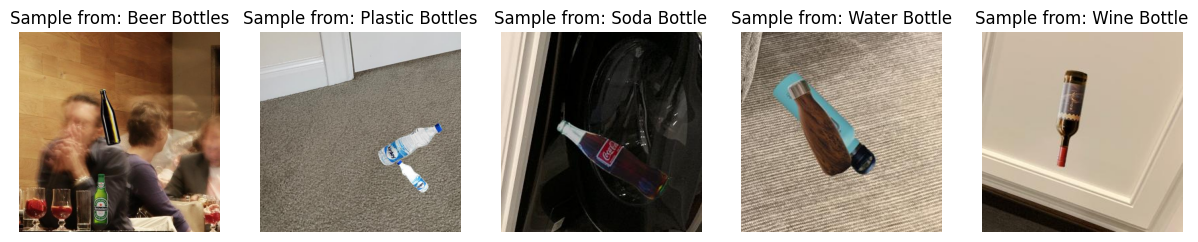

In [29]:
# ### 3.2. Sample Images
plt.figure(figsize=(15, 5))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_path, class_name)
    random_image = random.choice(os.listdir(class_dir))
    img = plt.imread(os.path.join(class_dir, random_image))
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img)
    plt.title(f'Sample from: {class_name}')
    plt.axis('off')
plt.show()

In [30]:
# ### 3.3. Image Size and Aspect Ratio Analysis
dimensions = []
print("\nReading image dimensions...")
for class_name in class_names:
    class_dir = os.path.join(data_path, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                dimensions.append({'class': class_name, 'width': width, 'height': height})
        except Exception as e:
            print(f"Could not read {img_path}: {e}")


Reading image dimensions...


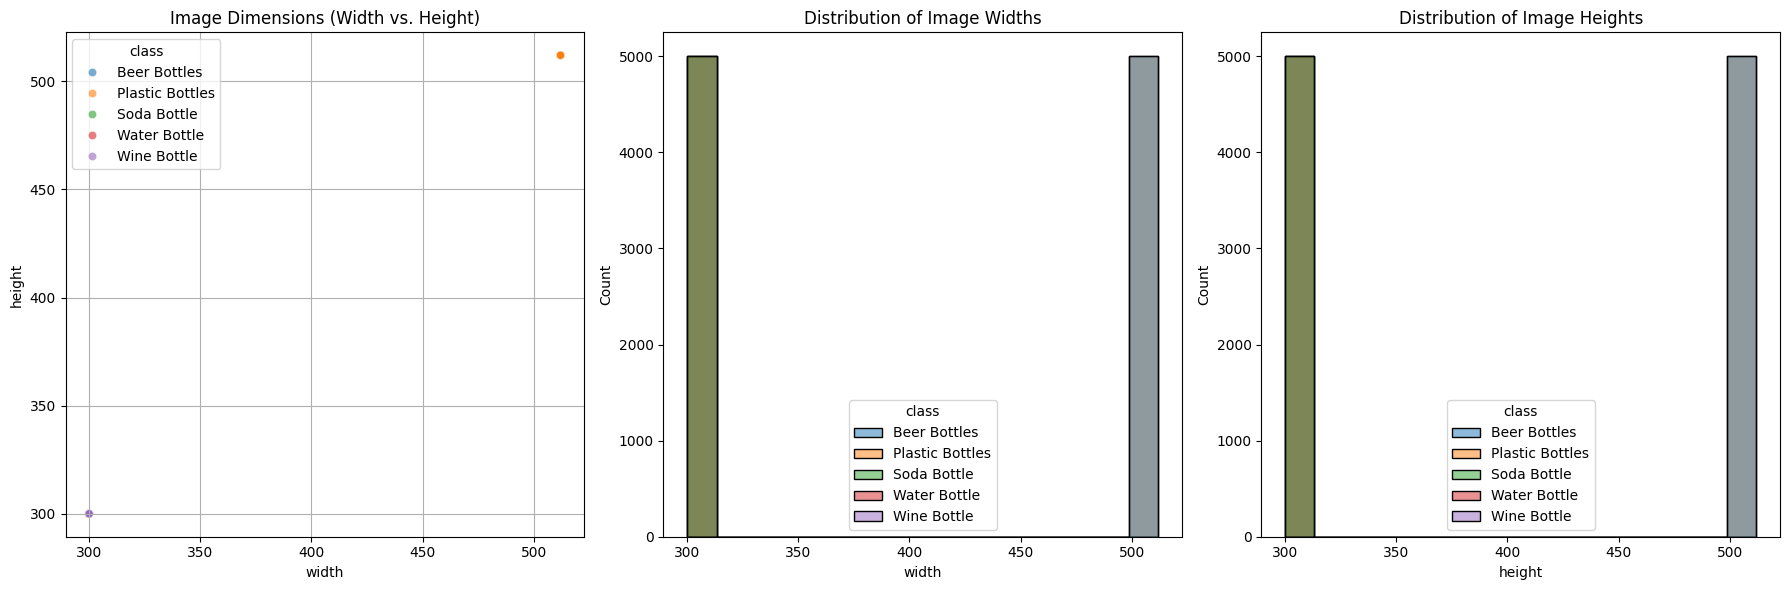

In [31]:
dim_df = pd.DataFrame(dimensions)
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
sns.scatterplot(data=dim_df, x='width', y='height', hue='class', alpha=0.6)
plt.title('Image Dimensions (Width vs. Height)')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.histplot(data=dim_df, x='width', hue='class', kde=True)
plt.title('Distribution of Image Widths')
plt.subplot(1, 3, 3)
sns.histplot(data=dim_df, x='height', hue='class', kde=True)
plt.title('Distribution of Image Heights')
plt.tight_layout()
plt.show()


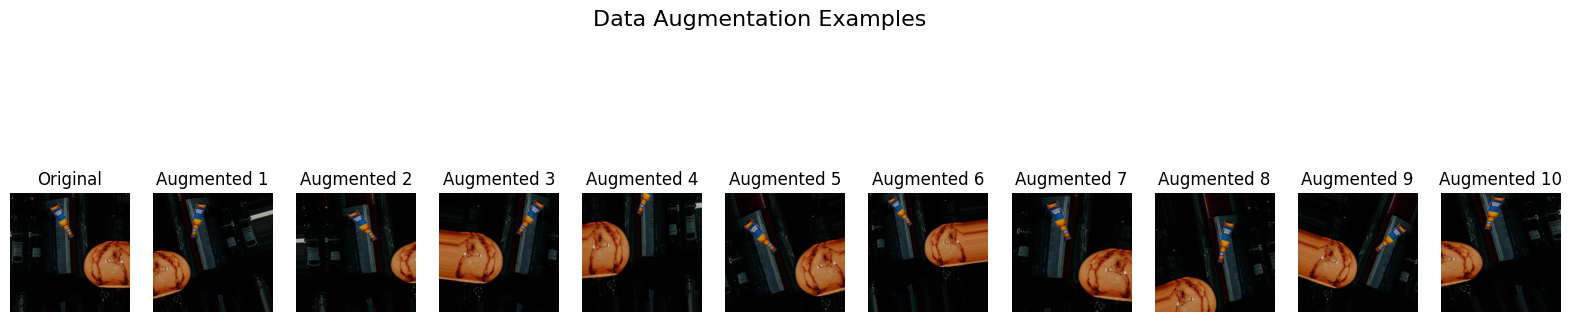

In [32]:
# ### 3.4. Data Augmentation Effect Visualization
datagen_vis = ImageDataGenerator(
    rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)
sample_class_dir = os.path.join(data_path, class_names[0])
sample_img_path = os.path.join(sample_class_dir, random.choice(os.listdir(sample_class_dir)))
img = plt.imread(sample_img_path)
img_array = np.expand_dims(img, axis=0)
augmented_images = [next(datagen_vis.flow(img_array, batch_size=1))[0].astype('uint8') for _ in range(10)]

plt.figure(figsize=(20, 5))
plt.subplot(1, 11, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 11, i + 2)
    plt.imshow(aug_img)
    plt.title(f"Augmented {i+1}")
    plt.axis('off')
plt.suptitle('Data Augmentation Examples', fontsize=16)
plt.show()

In [33]:
# ## 4. Data Augmentation & Loading
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\nClass Indices:", train_generator.class_indices)

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.

Class Indices: {'Beer Bottles': 0, 'Plastic Bottles': 1, 'Soda Bottle': 2, 'Water Bottle': 3, 'Wine Bottle': 4}


In [34]:
# ## 5. Model Building (Transfer Learning with InceptionV3)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 109, 109,  │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 109, 109,  │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 54, 54,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 54, 54,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 52, 52,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
# ## 6. Model Training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stopping]
)

In [ ]:
# ## 7. Performance Evaluation
loss, accuracy = model.evaluate(validation_generator)
print(f'\nValidation Accuracy: {accuracy*100:.2f}%')

# ### 7.1. Accuracy and Loss Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step


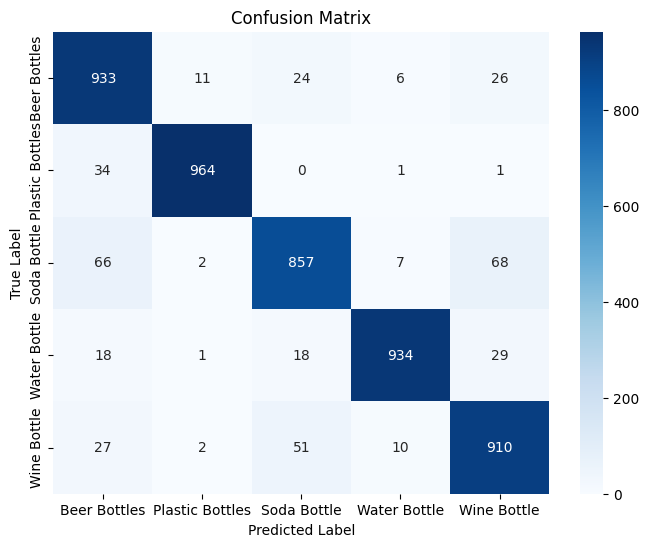


Classification Report
                 precision    recall  f1-score   support

   Beer Bottles       0.87      0.93      0.90      1000
Plastic Bottles       0.98      0.96      0.97      1000
    Soda Bottle       0.90      0.86      0.88      1000
   Water Bottle       0.97      0.93      0.95      1000
    Wine Bottle       0.88      0.91      0.89      1000

       accuracy                           0.92      5000
      macro avg       0.92      0.92      0.92      5000
   weighted avg       0.92      0.92      0.92      5000



In [37]:
# ### 7.2. Confusion Matrix & Classification Report
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_names))


Total misclassified images: 402



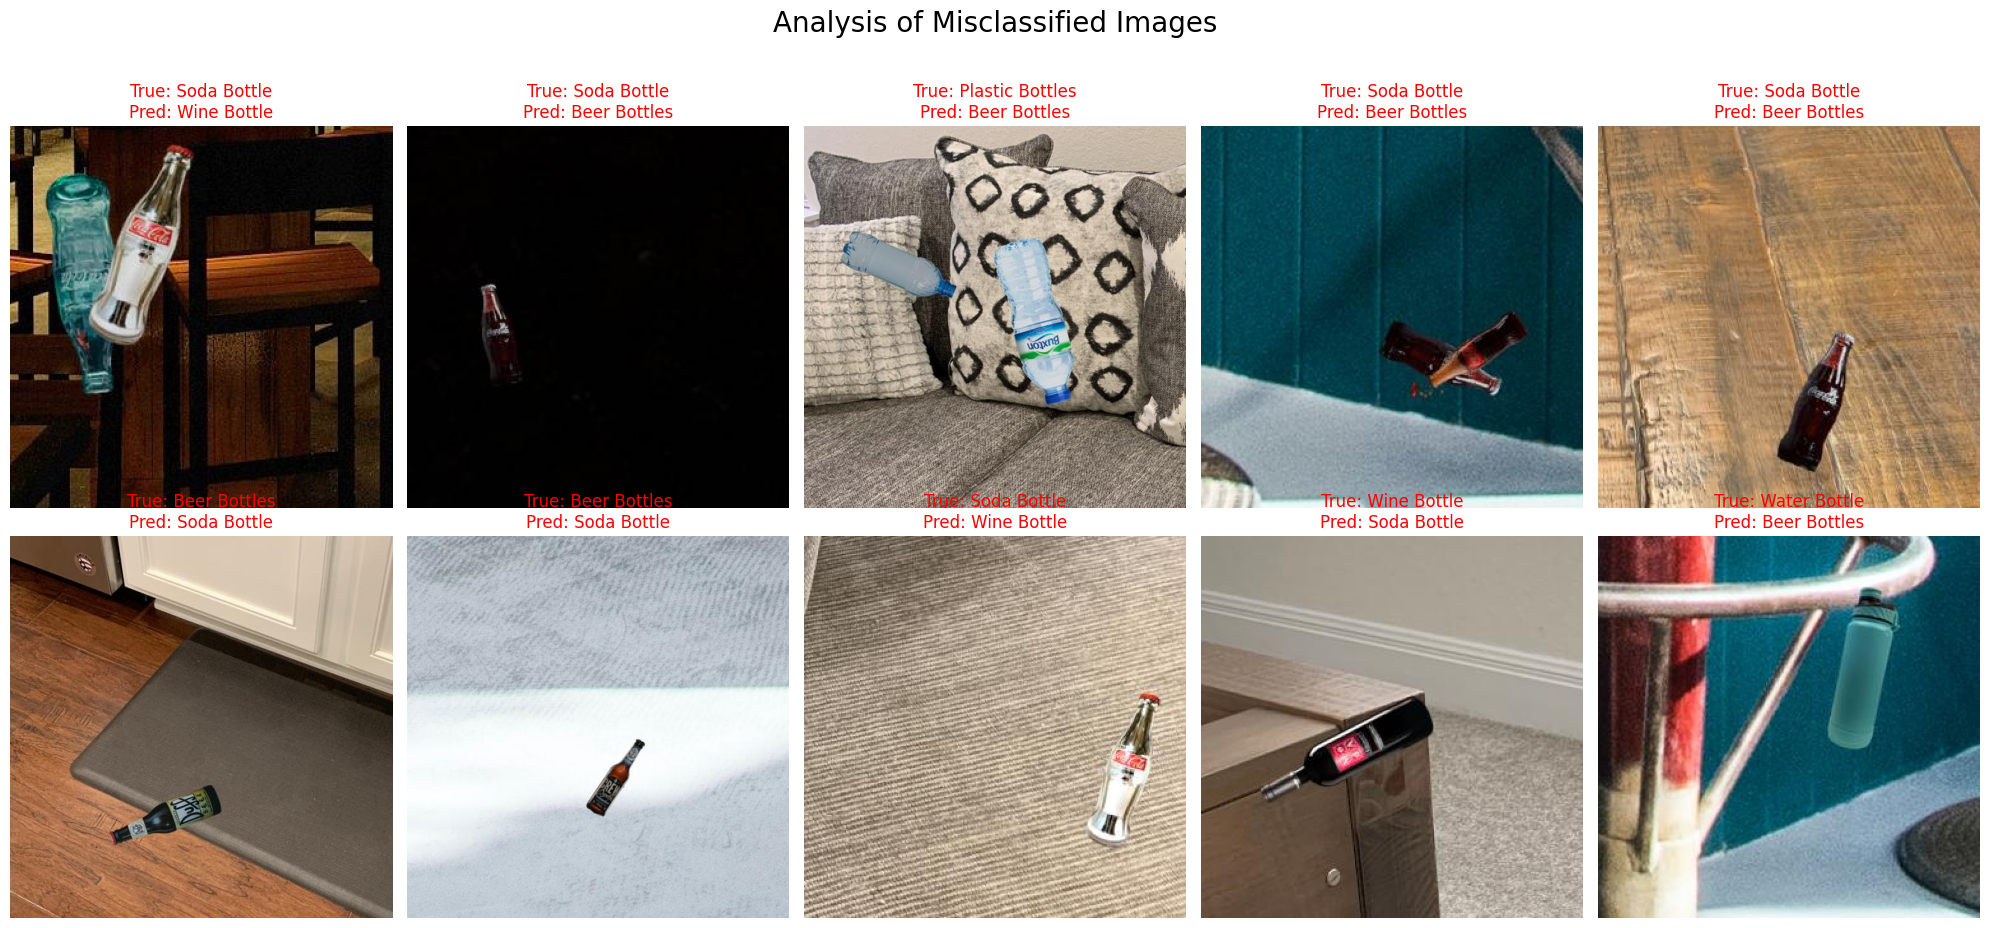

In [38]:
# ### 7.3. Analysis of Misclassified Images
misclassified_indices = np.where(y_pred != y_true)[0]

if len(misclassified_indices) > 0:
    print(f"\nTotal misclassified images: {len(misclassified_indices)}\n")

    plt.figure(figsize=(20, 10))
    random_indices = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        img_path = validation_generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.imshow(img)

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='red')
        plt.axis('off')

    plt.suptitle('Analysis of Misclassified Images', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Congratulations! No images were misclassified in the validation set.")